In [26]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


import pickle # To save the model
from functools import partial
import random

# The following is to be able to mount Google Drive
from google.colab import drive


# We import a function I prepared for you in the course library
! wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py
from visualization import plot_conf_mat


from typing import List

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger


# The following library is to plot the loss during training
# https://github.com/stared/livelossplot
! pip install livelossplot
from livelossplot import PlotLossesKerasTF

from pandas.plotting import scatter_matrix # For plots
import matplotlib.pyplot as plt # For plots


import os
from os.path import isfile

--2022-02-24 10:01:41--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13008 (13K) [text/plain]
Saving to: ‘visualization.py.1’

visualization.py.1  100%[===================>]  12.70K  --.-KB/s    in 0s      

2022-02-24 10:01:41 (77.9 MB/s) - ‘visualization.py.1’ saved [13008/13008]



In [16]:
# Load of the dataset
! wget https://raw.githubusercontent.com/theleos88/ml-for-highspeed-networks/master/data/other_switches/fastclick.csv

--2022-02-24 09:42:16--  https://raw.githubusercontent.com/theleos88/ml-for-highspeed-networks/master/data/other_switches/fastclick.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 136118 (133K) [text/plain]
Saving to: ‘fastclick.csv.2’

fastclick.csv.2     100%[===================>] 132.93K  --.-KB/s    in 0.01s   

2022-02-24 09:42:16 (8.81 MB/s) - ‘fastclick.csv.2’ saved [136118/136118]



In [18]:
# Read the full dataset
full_df = pd.read_csv('fastclick.csv.2')

data = full_df.to_numpy()

print (data)

[[1.01351730e+09 9.99857451e+08 1.01197765e+09 ... 1.00033906e+03
  1.00049712e+00            nan]
 [1.01480304e+09 1.00096043e+09 1.01405016e+09 ... 1.00027989e+03
  2.00078619e+00            nan]
 [1.01475625e+09 1.00115559e+09 1.01620506e+09 ... 1.00025461e+03
  3.00104201e+00            nan]
 ...
 [5.25702211e+08 7.92411603e+08 6.21517570e+08 ... 1.00025257e+03
  2.70072525e+01            nan]
 [5.25645552e+08 7.92766389e+08 6.21737358e+08 ... 1.00026473e+03
  2.80075101e+01            nan]
 [5.25779196e+08 7.92246934e+08 6.22063280e+08 ... 1.00024252e+03
  2.90077632e+01            nan]]


In [24]:
full_df.head(n=10)

,10000-128-branches,10000-1400-branches,10000-512-branches,10000-64-branches,2500-128-branches,2500-1400-branches,2500-512-branches,2500-64-branches,5000-128-branches,5000-1400-branches,5000-512-branches,5000-64-branches,500-128-branches,500-1400-branches,500-512-branches,500-64-branches,7500-128-branches,7500-1400-branches,7500-512-branches,7500-64-branches,10000-128-branch-load-misses,10000-1400-branch-load-misses,10000-512-branch-load-misses,10000-64-branch-load-misses,2500-128-branch-load-misses,2500-1400-branch-load-misses,2500-512-branch-load-misses,2500-64-branch-load-misses,5000-128-branch-load-misses,5000-1400-branch-load-misses,5000-512-branch-load-misses,5000-64-branch-load-misses,500-128-branch-load-misses,500-1400-branch-load-misses,500-512-branch-load-misses,500-64-branch-load-misses,7500-128-branch-load-misses,7500-1400-branch-load-misses,7500-512-branch-load-misses,7500-64-branch-load-misses,...,10000-512-ref-cycles,10000-64-ref-cycles,2500-128-ref-cycles,2500-1400-ref-cycles,2500-512-ref-cycles,2500-64-ref-cycles,5000-128-ref-cycles,5000-1400-ref-cycles,5000-512-ref-cycles,5000-64-ref-cycles,500-128-ref-cycles,500-1400-ref-cycles,500-512-ref-cycles,500-64-ref-cycles,7500-128-ref-cycles,7500-1400-ref-cycles,7500-512-ref-cycles,7500-64-ref-cycles,10000-128-task-clock,10000-1400-task-clock,10000-512-task-clock,10000-64-task-clock,2500-128-task-clock,2500-1400-task-clock,2500-512-task-clock,2500-64-task-clock,5000-128-task-clock,5000-1400-task-clock,5000-512-task-clock,5000-64-task-clock,500-128-task-clock,500-1400-task-clock,500-512-task-clock,500-64-task-clock,7500-128-task-clock,7500-1400-task-clock,7500-512-task-clock,7500-64-task-clock,Time,Unnamed: 621
0,1013517303,999857451,1011977653,1020049713,1007621845,1011685618,1018889440,1020281054,1021648998,1028875253,1016511292,999110667,1020172607,1020368794,1020243982,1020395008,1008016081,1018519841,1020326858,1017040045,1964764,1939017,1963542,1977775,1953999,1962789,1975729,1978114,1980773,1994916,1972903,1937675,1977951,1978649,1978134,1978470,1955210,1974476,1977906,1971867,...,2584647189,2590120739,2589962233,2585382364,2590117220,2590052944,2590158597,2590060902,2590354348,2585904700,2590061630,2590103124,2590149143,2590117503,2590438228,2590129263,2590072049,2590176817,1000.318485,1000.319500,1000.374447,1000.325511,1000.300713,1000.360928,1000.326554,1000.321512,1000.325350,1000.330001,1000.421134,1000.397505,1000.298605,1000.327420,1000.331364,1000.316407,1000.448063,1000.319530,1000.316412,1000.339061,1.000497118,NaN
1,1014803043,1000960433,1014050155,1021497480,1008946163,1015085911,1020297696,1021669727,1022918234,1030128978,1018230972,999437020,1021516079,1021702996,1021655386,1021687772,1009762769,1019701680,1021592795,1018293371,1964210,1938521,1963914,1977220,1953256,1965238,1974698,1977616,1980140,1993963,1971704,1978563,1978577,1977872,1977764,1977938,1954529,1973917,1977646,1971175,...,2584526287,2590045437,2589962507,2586253617,2590052762,2590033812,2590080775,2589997816,2590238784,2585682044,2589947506,2590055244,2590064693,2590044026,2590424061,2590050003,2590021470,2590057611,1000.281258,1000.271058,1000.284090,1000.283500,1000.254225,1000.352987,1000.284627,1000.276703,1000.281116,1000.266748,1000.367625,1000.317701,1000.241678,1000.278128,1000.283989,1000.271865,1000.416909,1000.278012,1000.260899,1000.279888,2.000786195,NaN
2,1014756247,1001155586,1016205056,1021394644,1008784320,1015001006,1019976906,1021586440,1022855735,1030214626,1018139751,1000223777,1021530981,1021621051,1021560728,1021633705,1009574195,1019738830,1021653039,1018335062,1964166,1938099,1967732,1977196,1953209,1965365,1974784,1977452,1979838,1994288,1971107,1936905,1977327,1977724,1977491,1977798,1954186,1973712,1977290,1971023,...,2585936666,2590077612,2589939014,2586330678,2590075384,2590070207,2590073907,2590027528,2590215393,2585738232,2589906794,2590098327,2590105533,2590112062,2590393398,2590095031,2590085876,2590117955,1000.247609,1000.243046,1000.249548,100

Above we have two approaches, one that allows us to gauge the behavior of the network by fixing the rate and varying the size of the packets routed; the other allowing the reverse operation. 

# Fixed Data size with variable rate 

---



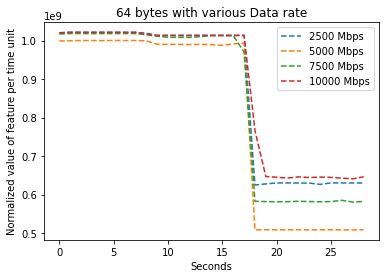

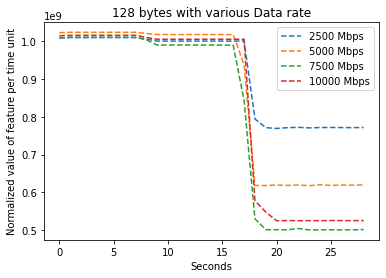

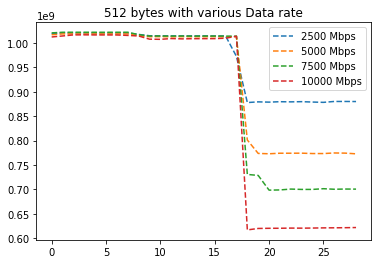

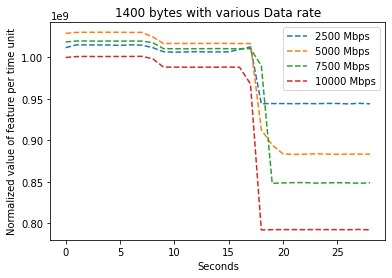

In [86]:
fig, ax = plt.subplots()

line1, = ax.plot(full_df['2500-64-branches'], label="2500 Mbps", linestyle='--')
line2, = ax.plot(full_df['5000-64-branches'], label="5000 Mbps", linestyle='--')
line3, = ax.plot(full_df['7500-64-branches'], label="7500 Mbps", linestyle='--')
line4, = ax.plot(full_df['10000-64-branches'], label="10000 Mbps", linestyle='--')
plt.xlabel('Seconds')
plt.ylabel('Normalized value of feature per time unit')
plt.title("64 bytes with various Data rate")
# Create a legend 
first_legend = ax.legend(handles=[line1,line2,line3, line4 ], loc='upper right')

################### 128

fig, ax = plt.subplots()

line1, = ax.plot(full_df['2500-128-branches'], label="2500 Mbps", linestyle='--')
line2, = ax.plot(full_df['5000-128-branches'], label="5000 Mbps", linestyle='--')
line3, = ax.plot(full_df['7500-128-branches'], label="7500 Mbps", linestyle='--')
line4, = ax.plot(full_df['10000-128-branches'], label="10000 Mbps", linestyle='--')
plt.xlabel('Seconds')
plt.ylabel('Normalized value of feature per time unit')
plt.title("128 bytes with various Data rate")
# Create a legend 
first_legend = ax.legend(handles=[line1,line2,line3, line4 ], loc='upper right')

################### 512

fig, ax = plt.subplots()

line1, = ax.plot(full_df['2500-512-branches'], label="2500 Mbps", linestyle='--')
line2, = ax.plot(full_df['5000-512-branches'], label="5000 Mbps", linestyle='--')
line3, = ax.plot(full_df['7500-512-branches'], label="7500 Mbps", linestyle='--')
line4, = ax.plot(full_df['10000-512-branches'], label="10000 Mbps", linestyle='--')
plt.title("512 bytes with various Data rate")
# Create a legend 
first_legend = ax.legend(handles=[line1,line2,line3, line4 ], loc='upper right')

################### 1400

fig, ax = plt.subplots()

line1, = ax.plot(full_df['2500-1400-branches'], label="2500 Mbps", linestyle='--')
line2, = ax.plot(full_df['5000-1400-branches'], label="5000 Mbps", linestyle='--')
line3, = ax.plot(full_df['7500-1400-branches'], label="7500 Mbps", linestyle='--')
line4, = ax.plot(full_df['10000-1400-branches'], label="10000 Mbps", linestyle='--')
plt.xlabel('Seconds')
plt.ylabel('Normalized value of feature per time unit')
plt.title("1400 bytes with various Data rate")
# Create a legend 
first_legend = ax.legend(handles=[line1,line2,line3, line4 ], loc='upper right')


# Fixed rate with variable Data size 

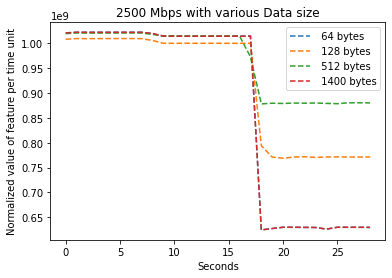

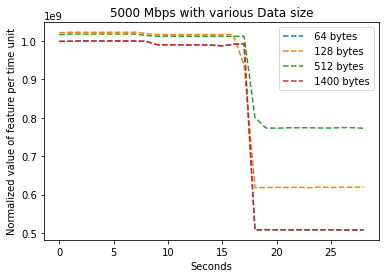

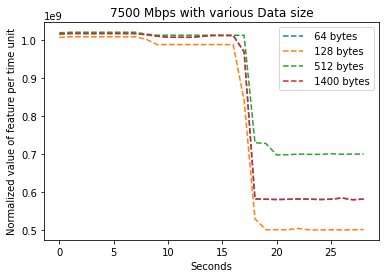

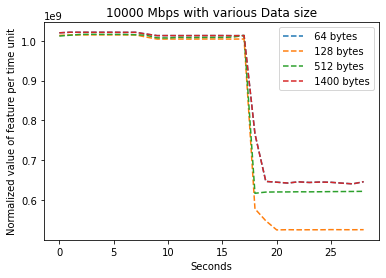

In [87]:

fig, ax = plt.subplots()

line1, = ax.plot(full_df['2500-64-branches'], label=" 64 bytes", linestyle='--')
line2, = ax.plot(full_df['2500-128-branches'], label=" 128 bytes", linestyle='--')
line3, = ax.plot(full_df['2500-512-branches'], label=" 512 bytes", linestyle='--')
line4, = ax.plot(full_df['2500-64-branches'], label=" 1400 bytes", linestyle='--')
plt.title("2500 Mbps with various Data size")
plt.xlabel('Seconds')
plt.ylabel('Normalized value of feature per time unit')
# Create a legend 
first_legend = ax.legend(handles=[line1,line2,line3, line4 ], loc='upper right')


fig, ax = plt.subplots()

line1, = ax.plot(full_df['5000-64-branches'], label=" 64 bytes", linestyle='--')
line2, = ax.plot(full_df['5000-128-branches'], label=" 128 bytes", linestyle='--')
line3, = ax.plot(full_df['5000-512-branches'], label=" 512 bytes", linestyle='--')
line4, = ax.plot(full_df['5000-64-branches'], label=" 1400 bytes", linestyle='--')
plt.xlabel('Seconds')
plt.ylabel('Normalized value of feature per time unit')
plt.title("5000 Mbps with various Data size")
# Create a legend 
first_legend = ax.legend(handles=[line1,line2,line3, line4 ], loc='upper right')


fig, ax = plt.subplots()

line1, = ax.plot(full_df['7500-64-branches'], label=" 64 bytes", linestyle='--')
line2, = ax.plot(full_df['7500-128-branches'], label=" 128 bytes", linestyle='--')
line3, = ax.plot(full_df['7500-512-branches'], label=" 512 bytes", linestyle='--')
line4, = ax.plot(full_df['7500-64-branches'], label=" 1400 bytes", linestyle='--')
plt.xlabel('Seconds')
plt.ylabel('Normalized value of feature per time unit')
plt.title("7500 Mbps with various Data size")
# Create a legend 
first_legend = ax.legend(handles=[line1,line2,line3, line4 ], loc='upper right')


fig, ax = plt.subplots()

line1, = ax.plot(full_df['10000-64-branches'], label=" 64 bytes", linestyle='--')
line2, = ax.plot(full_df['10000-128-branches'], label=" 128 bytes", linestyle='--')
line3, = ax.plot(full_df['10000-512-branches'], label=" 512 bytes", linestyle='--')
line4, = ax.plot(full_df['10000-64-branches'], label=" 1400 bytes", linestyle='--')
plt.xlabel('Seconds')
plt.ylabel('Normalized value of feature per time unit')
plt.title("10000 Mbps with various Data size")
# Create a legend 
first_legend = ax.legend(handles=[line1,line2,line3, line4 ], loc='upper right')
